<a href="https://colab.research.google.com/github/harsh2k1/Project-Multiple-Disease-Prediction-Web-App/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold , StratifiedKFold
kfold = StratifiedKFold(n_splits=5)
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report , plot_confusion_matrix , \
plot_precision_recall_curve, plot_roc_curve , roc_auc_score , recall_score
from sklearn.preprocessing import StandardScaler , RobustScaler , MinMaxScaler , LabelEncoder
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import statistics as stats

In [3]:
path = 'stroke-data.csv'
df = pd.read_csv(path)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df['bmi'].fillna(df['bmi'].mean(),inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Pre-Processing

In [8]:
columns = ['gender','ever_married','work_type','Residence_type','smoking_status']
for column in columns:
  print('Unique value for ',column,'are: ',df[column].unique())


Unique value for  gender are:  ['Male' 'Female' 'Other']
Unique value for  ever_married are:  ['Yes' 'No']
Unique value for  work_type are:  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Unique value for  Residence_type are:  ['Urban' 'Rural']
Unique value for  smoking_status are:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [9]:
df['smoking_status'].replace({'Unknown':stats.mode(df['smoking_status'])}, inplace = True)
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

In [10]:
df = pd.get_dummies(df,drop_first = True)
df.shape

(5110, 17)

In [11]:
df.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

## Data-Splitting

In [12]:
X = df.drop(['id','stroke'],axis = 1)
y = df['stroke']

In [13]:
X_train , X_test , y_train , y_test = train_test_split(X, y , test_size = 0.20, random_state = 42)
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((4088, 15), (1022, 15), (4088,), (1022,))

In [14]:
# Creating a dataframe to keep record of auc scores
model = []
roc_auc = []
def performance(new_model , new_score):
    model.append(new_model)
    roc_auc.append(new_score)
    score_df = pd.DataFrame(zip(model , roc_auc) , columns = ['Model', 'ROC_AUC_Score'])
    #print(score_df)
    return score_df

In [15]:
# Define a function to compute Precision, Recall and F1 score
model_name = []
precision_list = []
recall_list = []
F1_list = []
def get_pre_rec_f1(model , new_model_name):

    if new_model_name == 'Artificial Neural Network':
        model_name.append(new_model_name)
        proba = model.predict(X_test)
        y_pred_ann = (proba > 0.5)
        #y_pred_ann = clf_ann.predict(X_test)
        roc_auc_ann = roc_auc_score(y_test, y_pred_ann)
        tp, fp, fn, tn = confusion_matrix(y_test, y_pred_ann).ravel()
        precision = tp / (tp + fp)
        precision_list.append(precision)
        recall = tp / (tp + fn)
        recall_list.append(recall)
        F1 = (2 * precision * recall) / (precision + recall)
        F1_list.append(F1)
        evaluation_df = pd.DataFrame(zip(model_name , precision_list , recall_list , F1_list) , columns = \
                                 ['Model','Precision', 'Recall', 'F1_Score'])
        #print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nF1 score:{F1:.3f}')
        return evaluation_df
    else: 
        model_name.append(new_model_name)
        y_pred = model.predict(X_test)
        tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
        precision = tp / (tp + fp)
        precision_list.append(precision)
        recall = tp / (tp + fn)
        recall_list.append(recall)
        F1 = (2 * precision * recall) / (precision + recall)
        F1_list.append(F1)
        evaluation_df = pd.DataFrame(zip(model_name , precision_list , recall_list , F1_list) , columns = \
                                 ['Model','Precision', 'Recall', 'F1_Score'])
        #print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nF1 score:{F1:.3f}')
        return evaluation_df

# Modelling
## Random Forest

In [16]:
# Random Forest
# Hyperparameter tuning

# Create parameter grid  
param_grid = {
    'max_depth': [60, 90, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Instantiate the model
clf_rf = RandomForestClassifier()

# Instantiate grid search model
grid_search = GridSearchCV(estimator = clf_rf, param_grid = param_grid,    
                          cv = 3, n_jobs = -1, verbose = 1)

# Fit grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'max_depth': 60,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [17]:
# Use the best parameters to fit the model

clf_rf = RandomForestClassifier(**grid_search.best_params_)   
clf_rf.fit(X_train,y_train)

scores = cross_val_score(clf_rf, X_train, y_train, scoring ="roc_auc", cv = 5)
roc_auc_rf = np.mean(scores)
performance('Random Forest',roc_auc_rf)

,Model,ROC_AUC_Score
0,Random Forest,0.812581


In [18]:
get_pre_rec_f1(clf_rf,'Random Forest')

,Model,Precision,Recall,F1_Score
0,Random Forest,1.0,0.939335,0.968718


## XGBoost

In [19]:
# XGBoost
from sklearn.model_selection import RandomizedSearchCV
# Number of trees
n_estimators = np.arange(200,1000,200)

# Minimum loss reduction required to make a further partition on a leaf node of the tree
# The larger gamma is, the more conservative the algorithm will be
gamma = np.arange(0.1,0.4,0.1)

# Default 0.3, range(0,1)
learning_rate = np.arange(0.1,0.6,0.1)

# Maximum number of levels in tree
max_depth = list(range(3,8,1))

# Subsample ratio of the training instances.Range(0,1)
subsample = np.arange(0.5,0.9,0.1)

# Subsample ratio of columns when constructing each tree. Range(0,1)
colsample_bytree = np.arange(0.5,0.9,0.1)

# Control the balance of positive and negative weights
# Sum(negative instances) / sum(positive instances)
scale_pos_weight = [1,3.5]


# Create the random grid
random_grid_xgb = {'n_estimators': n_estimators,
                   'gamma': gamma,
                   'learning_rate':learning_rate,
                   'max_depth': max_depth,
                   'subsample':subsample,
                   'colsample_bytree':colsample_bytree,
                   'scale_pos_weight':scale_pos_weight
                  }
print(random_grid_xgb)

{'n_estimators': array([200, 400, 600, 800]), 'gamma': array([0.1, 0.2, 0.3, 0.4]), 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'max_depth': [3, 4, 5, 6, 7], 'subsample': array([0.5, 0.6, 0.7, 0.8]), 'colsample_bytree': array([0.5, 0.6, 0.7, 0.8]), 'scale_pos_weight': [1, 3.5]}


In [20]:
# Use randomized search to find best parameters

xgboost = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = xgboost, 
                                param_distributions = random_grid_xgb, 
                                n_iter = 5, 
                                cv = 3, 
                                verbose=1, 
                                random_state=42, 
                                n_jobs = -1,
                                scoring ='roc_auc')


xgb_random.fit(X_train, y_train)   

print(xgb_random.best_params_,xgb_random.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[16:16:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'subsample': 0.7, 'scale_pos_weight': 3.5, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7} 0.804439915428361


In [21]:
# Use the best parameters to fit the model

clf_xgb = XGBClassifier(**xgb_random.best_params_)   
clf_xgb.fit(X_train,y_train)
scores = cross_val_score(clf_xgb, X_train, y_train, scoring ="roc_auc", cv = 5)
roc_auc_xgb = np.mean(scores)
performance('XGBoost',roc_auc_xgb)

[16:16:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Model,ROC_AUC_Score
0,Random Forest,0.812581
1,XGBoost,0.820270


In [22]:
get_pre_rec_f1(clf_xgb,'XGBoost')

,Model,Precision,Recall,F1_Score
0,Random Forest,1.00000,0.939335,0.968718
1,XGBoost,0.98125,0.944835,0.962698


# Voting Classifier

In [23]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

hard_voting_clf = VotingClassifier(estimators=[('knn', KNeighborsClassifier()),('lr',LogisticRegression()),('svm', SVC(kernel='rbf')),
                                   ('dt', DecisionTreeClassifier()), ('rf',clf_rf ) , ('xgb', clf_xgb)],voting = 'hard')
hard_voting_clf.fit(X_train, y_train)
accuracy_vclf = hard_voting_clf.score(X_test , y_test)
print('Accuracy = ',accuracy_vclf)
scores = cross_val_score(estimator = hard_voting_clf,X=X_test,y=y_test, scoring='recall_weighted', cv=kfold)
recall_vclf = np.mean(scores)
print('Recall = ',recall_vclf)

[16:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy =  0.9393346379647749
[16:17:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:04] WARNING: C:/Users/Administra

In [24]:
auc = 0.9125
print('ROC_AUC = ',auc)

ROC_AUC =  0.9125


In [25]:
clf_ann = Sequential()
clf_ann.add(Dense(16,input_dim = X.shape[1],kernel_initializer = 'normal',activation = 'relu'))
clf_ann.add(Dropout(0.1))
clf_ann.add(Dense(8,kernel_initializer = 'normal',activation = 'relu'))
clf_ann.add(Dropout(0.1))
clf_ann.add(Dense(1,activation = 'sigmoid'))
    
adam = Adam(lr = 0.1)
clf_ann.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
clf_ann.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
409/409 [==============================] - 1s 1ms/step - loss: 0.2382 - accuracy: 0.9525
Epoch 2/10
409/409 [==============================] - 0s 1ms/step - loss: 0.1875 - accuracy: 0.9543
Epoch 3/10
409/409 [==============================] - 0s 1ms/step - loss: 0.1879 - accuracy: 0.9543
Epoch 4/10
409/409 [==============================] - 0s 1ms/step - loss: 0.1867 - accuracy: 0.9543
Epoch 5/10
409/409 [==============================] - 1s 1ms/step - loss: 0.1874 - accuracy: 0.9543
Epoch 6/10
409/409 [==============================] - 1s 1ms/step - loss: 0.1871 - accuracy: 0.9543
Epoch 7/10
409/409 [==============================] - 0s 1ms/step - loss: 0.1873 - accuracy: 0.9543
Epoch 8/10
409/409 [==============================] - 1s 1ms/step - loss: 0.1876 - accuracy: 0.9543
Epoch 9/10
409/409 [==============================] - 1s 1ms/step - loss: 0.1868 - accuracy: 0.9543
Epoch 10/10
409/409 [==============================] - 1s 1ms/step - loss: 0.1877 - accuracy: 0.9543

In [26]:
# Calculating ROC_AUC score

proba = clf_ann.predict(X_test)
y_pred_ann = (proba > 0.5)
#y_pred_ann = clf_ann.predict(X_test)
roc_auc_ann = roc_auc_score(y_test, y_pred_ann)
performance('Artificial Neural Network', roc_auc_ann)

,Model,ROC_AUC_Score
0,Random Forest,0.812581
1,XGBoost,0.820270
2,Artificial Neural Network,0.500000


In [27]:
get_pre_rec_f1(clf_ann , 'Artificial Neural Network')

,Model,Precision,Recall,F1_Score
0,Random Forest,1.00000,0.939335,0.968718
1,XGBoost,0.98125,0.944835,0.962698
2,Artificial Neural Network,1.00000,0.939335,0.968718


# Experimental Analysis

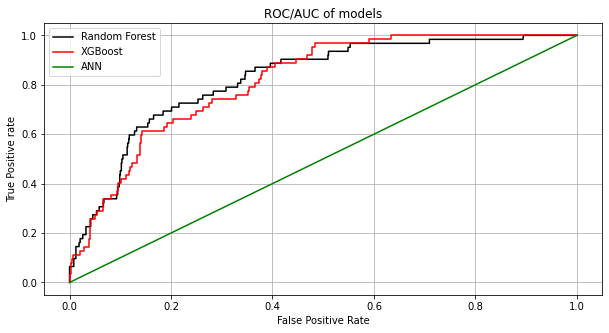

In [31]:
# Plot ROC_AUC curve of 3 models
from sklearn.metrics import roc_curve 
fig,ax=plt.subplots(figsize=(10,5))

#plot_roc_curve(clf_lr, X_test, y_test,ax=ax, color="blue",label='Logistic Regression')
plot_roc_curve(clf_rf, X_test, y_test,ax=ax, color="black",label='Random Forest')
plot_roc_curve(clf_xgb, X_test, y_test,ax=ax, color="red",label='XGBoost')
#plot_roc_curve(clf_gnb , X_test , y_test , ax=ax , color = 'yellow' , label = 'Gaussian NB')
#plot_roc_curve(model , X_test , y_test , ax = ax , color = 'green' , label = 'ANN')

# ROC_AUC curve for ANN
proba = clf_ann.predict(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test, proba, pos_label=1)
#plt.subplot(ax)
plt.plot(fpr1, tpr1,color='green', label='ANN')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc = 'best')
plt.title('ROC/AUC of models')
plt.grid()
#plt.savefig('Comparison_of_models')

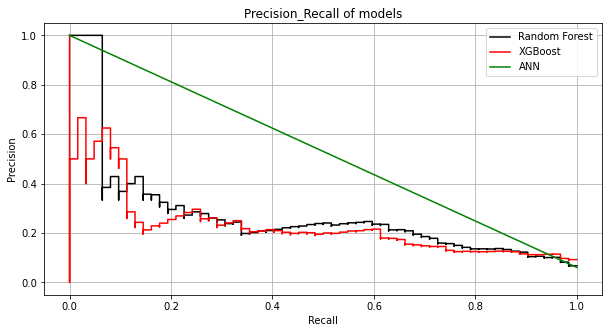

In [30]:
# Precision_recall curves
from sklearn.metrics import precision_recall_curve
fig,ax=plt.subplots(figsize=(10,5))

#plot_precision_recall_curve(clf_lr, X_test, y_test, ax=ax,color="blue",label='Logistic Regression')
plot_precision_recall_curve(clf_rf, X_test, y_test, ax=ax,color="black",label='Random Forest')
plot_precision_recall_curve(clf_xgb, X_test, y_test, ax=ax,color="red",label='XGBoost')
#plot_precision_recall_curve(clf_gnb , X_test , y_test , ax = ax , color = 'yellow' , label = 'Gaussian NB')

# Precision-Recall curve  for ANN
proba = clf_ann.predict(X_test)
ann_precision, ann_recall, _ = precision_recall_curve(y_test, proba)
ann_f1, ann_auc = 0.818182, 0.81
plt.plot(ann_recall, ann_precision, label='ANN' , color = 'green')



plt.title('Precision_Recall of models')
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
#plt.savefig('PR model_comparison')